In [165]:
import sys
sys.path.insert(0, '..')

In [166]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [167]:
#extra_bad = None
#extra_bad = np.isnan(np.zeros((64, 64)).at[35,60].set(np.nan))


In [168]:
wid = 128
oversample = 4

nwavels = 10
npoly=2

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


files = [
    'n8yj53vfq_cal.fits'

]

ddir = "../data/MAST_2025-03-02T22_29_29.259Z/HST/"

files = ["n8ku01ffq_cal.fits"]

exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

#exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

Filename: ../data/MAST_2025-03-02T22_29_29.259Z/HST/n8ku01ffq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None
Version 4.4.1
extra bad


In [169]:
data = '../data/MAST_2024-09-27T00_15_31.056Z/HST/'

files = """
na2a12jmq_cal.fits
na2a12jnq_cal.fits
na2a12joq_cal.fits
na2a12jpq_cal.fits
na2a12jqq_cal.fits
na2a12jxq_cal.fits
na2a12jzq_cal.fits
na2a12k0q_cal.fits
na2a12k1q_cal.fits
na2a12k2q_cal.fits
na2a12k9q_cal.fits
na2a12kbq_cal.fits
na2a12kcq_cal.fits
na2a12kdq_cal.fits
na2a12keq_cal.fits
na2a12klq_cal.fits
na2a12knq_cal.fits
na2a12koq_cal.fits
na2a12kpq_cal.fits
na2a12kqq_cal.fits
na2a12kxq_cal.fits
na2a12kzq_cal.fits
na2a12l0q_cal.fits
na2a12l1q_cal.fits
na2a12l2q_cal.fits
na2a12lgq_cal.fits
na2a12liq_cal.fits
na2a12ljq_cal.fits
na2a12lkq_cal.fits
na2a12llq_cal.fits
na2a12lsq_cal.fits
na2a12luq_cal.fits
na2a12lvq_cal.fits
na2a12lwq_cal.fits
na2a12lxq_cal.fits
na2a12m4q_cal.fits
na2a12m6q_cal.fits
na2a12m7q_cal.fits
na2a12m8q_cal.fits
na2a12m9q_cal.fits
na2a12mgq_cal.fits
na2a12miq_cal.fits
na2a12mjq_cal.fits
na2a12mkq_cal.fits
na2a12mlq_cal.fits
na2a12msq_cal.fits
na2a12muq_cal.fits
na2a12mvq_cal.fits
na2a12mwq_cal.fits
na2a12mxq_cal.fits
na2a12n4q_cal.fits
na2a12n6q_cal.fits
na2a12n7q_cal.fits
na2a12n8q_cal.fits
na2a12n9q_cal.fits
""".split()

print(files)


#exposures_single = [exposure_from_file(data+f, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for f in files][2:5]

['na2a12jmq_cal.fits', 'na2a12jnq_cal.fits', 'na2a12joq_cal.fits', 'na2a12jpq_cal.fits', 'na2a12jqq_cal.fits', 'na2a12jxq_cal.fits', 'na2a12jzq_cal.fits', 'na2a12k0q_cal.fits', 'na2a12k1q_cal.fits', 'na2a12k2q_cal.fits', 'na2a12k9q_cal.fits', 'na2a12kbq_cal.fits', 'na2a12kcq_cal.fits', 'na2a12kdq_cal.fits', 'na2a12keq_cal.fits', 'na2a12klq_cal.fits', 'na2a12knq_cal.fits', 'na2a12koq_cal.fits', 'na2a12kpq_cal.fits', 'na2a12kqq_cal.fits', 'na2a12kxq_cal.fits', 'na2a12kzq_cal.fits', 'na2a12l0q_cal.fits', 'na2a12l1q_cal.fits', 'na2a12l2q_cal.fits', 'na2a12lgq_cal.fits', 'na2a12liq_cal.fits', 'na2a12ljq_cal.fits', 'na2a12lkq_cal.fits', 'na2a12llq_cal.fits', 'na2a12lsq_cal.fits', 'na2a12luq_cal.fits', 'na2a12lvq_cal.fits', 'na2a12lwq_cal.fits', 'na2a12lxq_cal.fits', 'na2a12m4q_cal.fits', 'na2a12m6q_cal.fits', 'na2a12m7q_cal.fits', 'na2a12m8q_cal.fits', 'na2a12m9q_cal.fits', 'na2a12mgq_cal.fits', 'na2a12miq_cal.fits', 'na2a12mjq_cal.fits', 'na2a12mkq_cal.fits', 'na2a12mlq_cal.fits', 'na2a12ms

In [170]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    #"rot": 0.,
    "softening": 2.,
    "bias": {},
    "jitter": {},
    #"displacement": 1.#1e5#{}
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([6., 6.])#*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["displacement"][exp.fit.get_key(exp, "displacement")] = 1e6

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample

model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
#model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

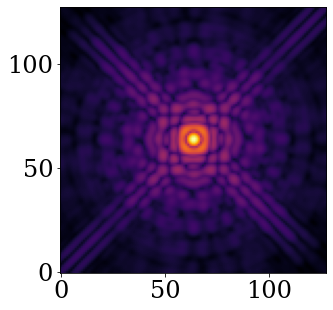

In [171]:
plt.imshow(exposures_single[0].fit(model_single,exposures_single[0])**0.125)

In [172]:
#stop

In [173]:
exposures_single[0].bad[35,60]

Array(False, dtype=bool)

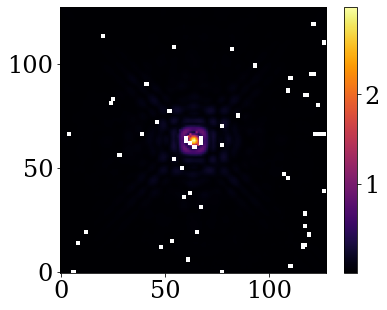

In [174]:
plt.imshow(exposures_single[0].err)
plt.colorbar()

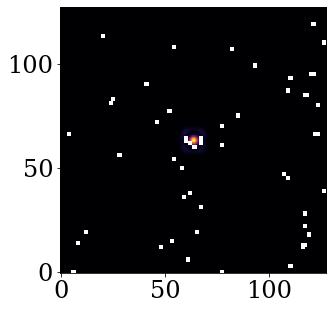

In [175]:
plt.imshow(exposures_single[0].data)

In [176]:
np.nanmin(exposures_single[0].err)

Array(0.01057486, dtype=float64)

In [177]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))

In [178]:
loss_fn(params, exposures_single, model_single)

Array(17457041.36952937, dtype=float64)

In [179]:
#potat

In [180]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    "positions": opt(g*50, 0),
    "spectrum": opt(g*80, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*50, 30),
    "cold_mask_rot": opt(g*10, 50),
    "bias": opt(g*30, 20),
    "aberrations": opt(g*40,80),#, (80, 2)),#, (150, g*0.2)),
    #"displacement": opt(g*30, 150),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [181]:
losses, models = optimise(params, model_single, exposures_single, things, 300)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'n8ku01ffq': {'positions': Array([[8.26181010e+07, 1.18494212e+07],
       [1.18494212e+07, 1.23439732e+08]], dtype=float64), 'spectrum': Array([[1.13498630e+09, 1.08652747e+07],
       [1.08652747e+07, 6.84284967e+07]], dtype=float64), 'cold_mask_shift': Array([[-618807.41183862,  257724.13738958],
       [ 257724.13738958, -590970.48868862]], dtype=float64), 'cold_mask_rot': Array([[-159667.66356078]], dtype=float64), 'bias': Array([[29534951.75142675]], dtype=float64), 'aberrations': Array([[ 2.32761148e+02, -3.26676945e+02,  4.50777242e+02,
         1.91525309e+02, -3.64263859e+01, -7.73256564e-01,
         2.24122818e+02,  4.96262761e+02,  1.60782487e+02,
        -2.35458629e+02,  1.19469612e+02, -7.33850956e+01,
        -4.79199756e+02,  4.50863476e+02, -1.01106717e+02,
        -2.31035248e+02,  1.31899831e+02, -1.14606776e+02,
         1.76481932e+02,  1.42633105e+02, -1.95138589e+02,
        -2.99002392e+01,  1.29071055e+01,  2.86173781e+01,
         5.89178204e+01, -1.1229154

  0%|          | 0/300 [00:00<?, ?it/s]

In [182]:
losses[-1]

Array(2291802.27382277, dtype=float64)

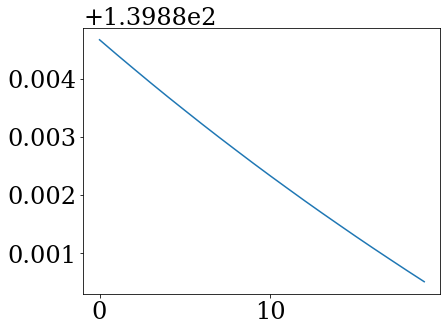

In [183]:
plt.plot(np.asarray(losses[-20:])/wid**2)

6


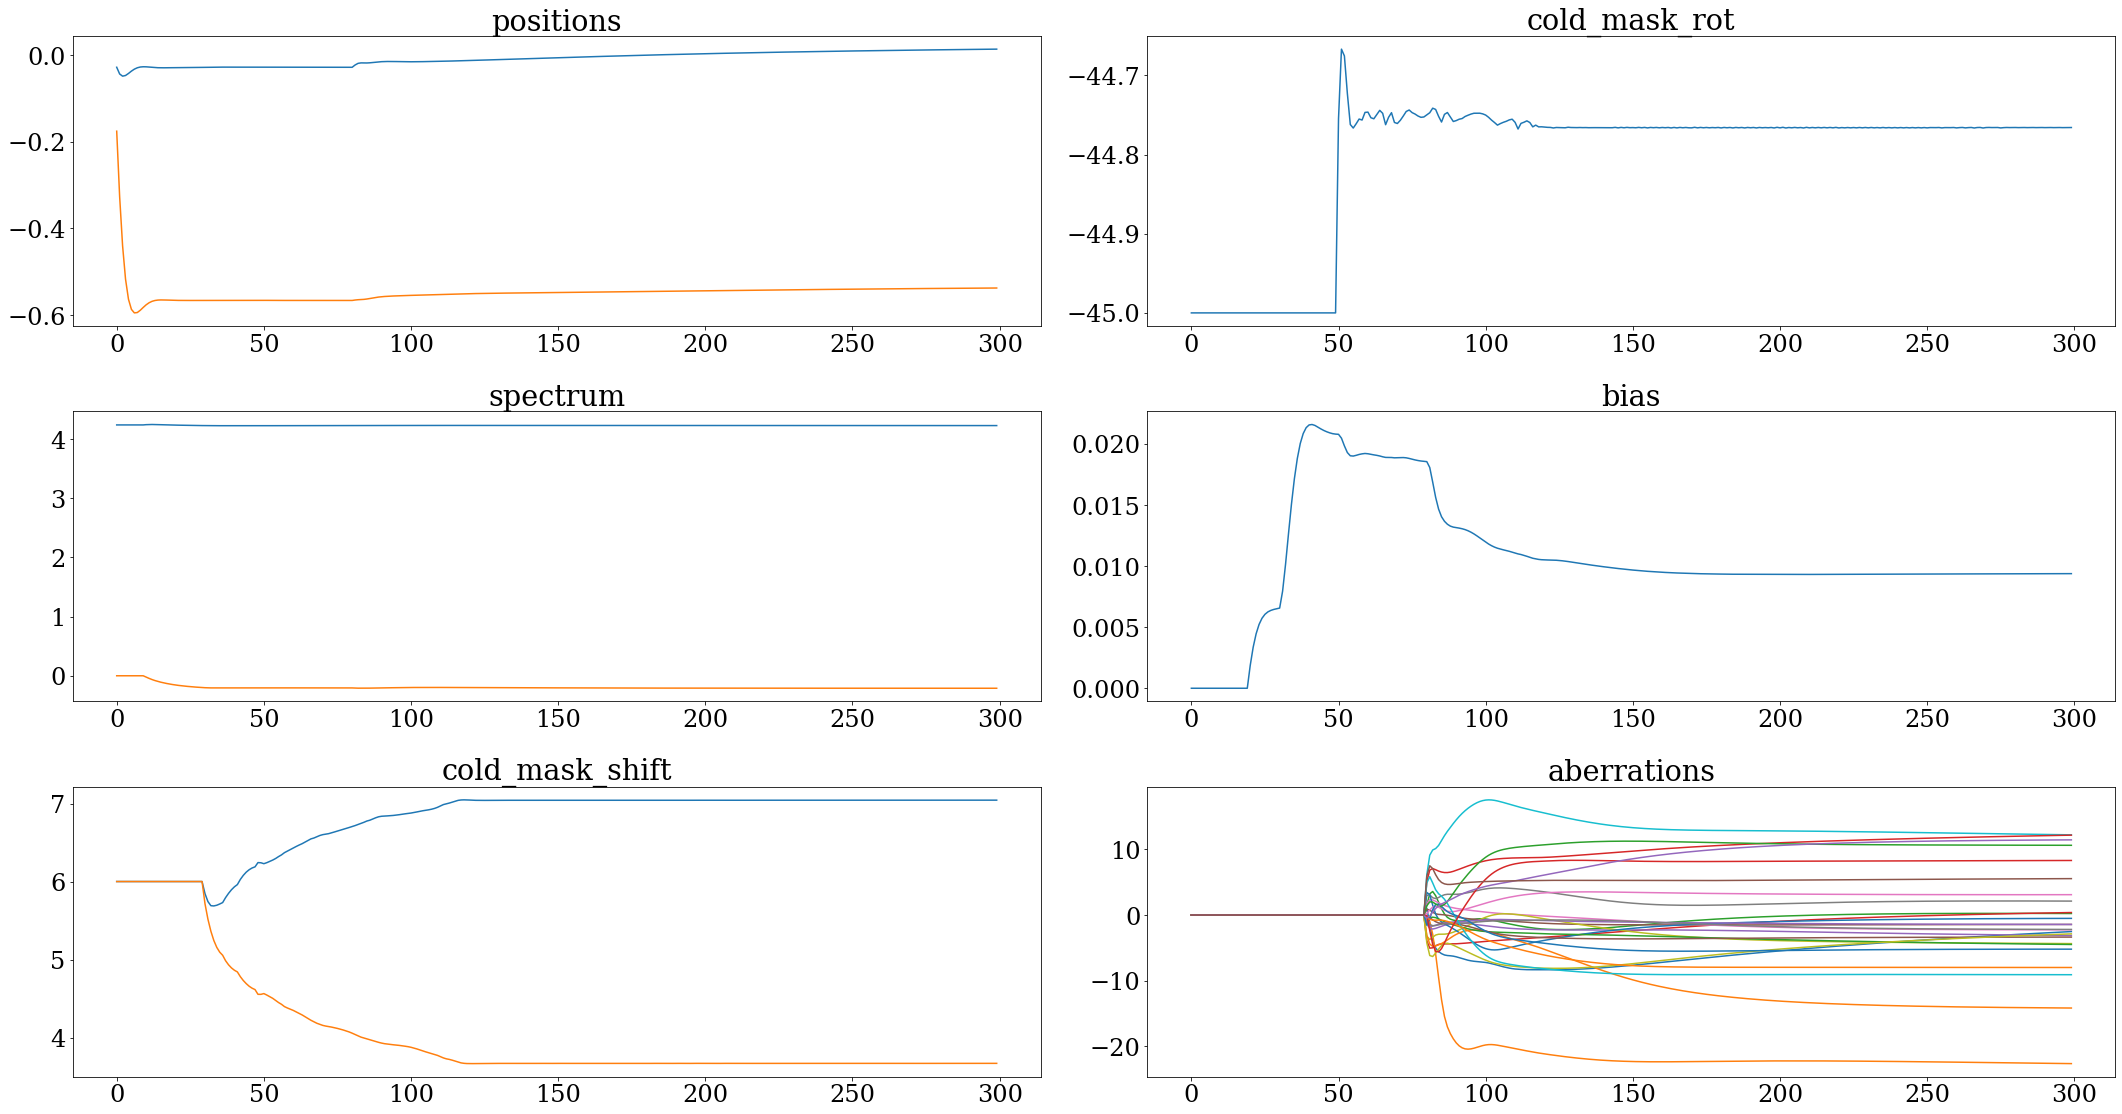

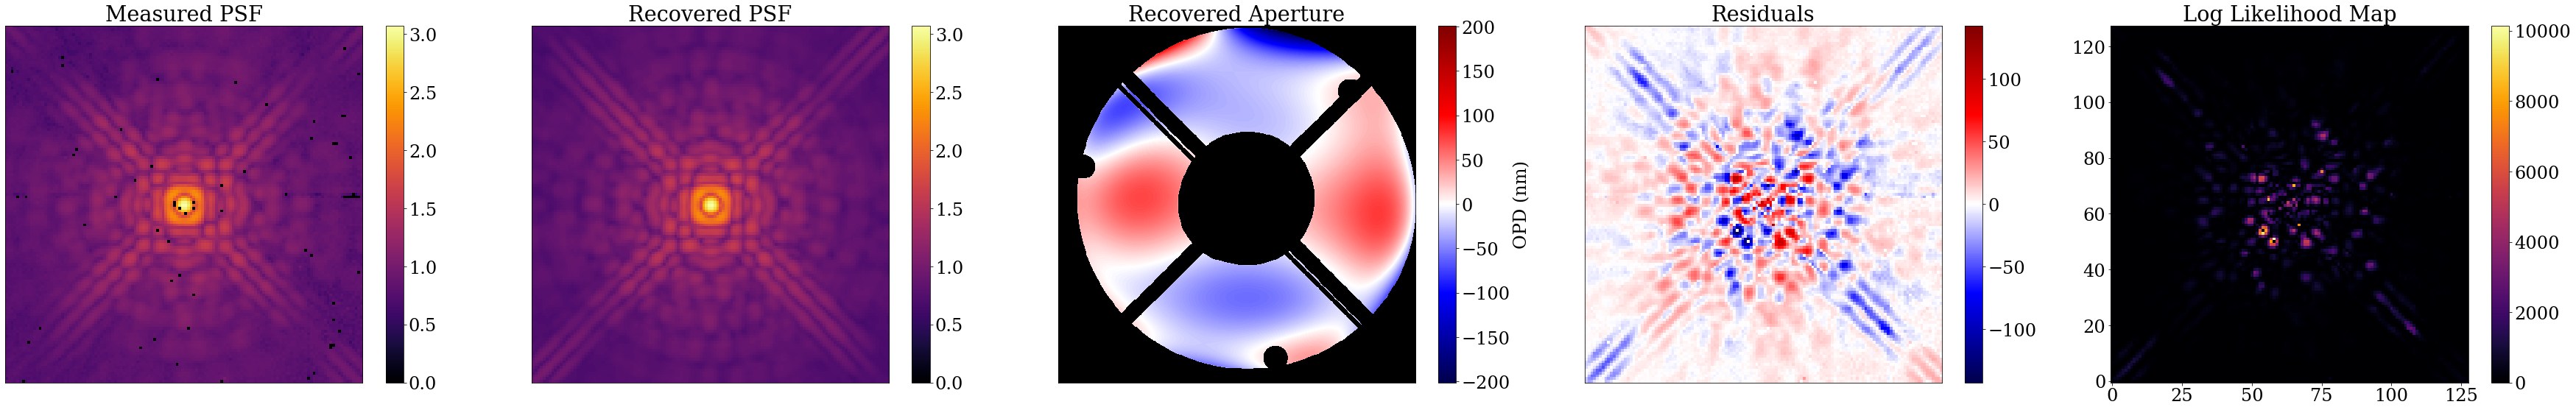

In [184]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [185]:
models[-1].params

{'aberrations': {'n8ku01ffq': Array([ -2.51382728, -22.63702812,   0.23852275,   0.38748642,
          -3.11629263,  -1.42662539,  -2.24600893,   2.12922263,
          -4.34642299,  12.22670523,  -0.50408175, -14.16640272,
          -4.48148004,  12.18006492,  -1.43143064,  -3.35586146,
           3.10785303,  -2.18850707,  -2.86483135,  -9.08849907,
          -5.19630143,  -7.98900646,  10.63372852,   8.31977872,
          11.45946476,   5.55345348], dtype=float64)},
 'bias': {'n8ku01ffq': Array(0.00938197, dtype=float64)},
 'cold_mask_rot': {'F170M': Array(-44.76588448, dtype=float64)},
 'cold_mask_scale': {'F170M': Array([1., 1.], dtype=float64)},
 'cold_mask_shear': {'F170M': Array([0., 0.], dtype=float64)},
 'cold_mask_shift': {'n8ku01ffq': Array([7.04289671, 3.66971072], dtype=float64)},
 'jitter': {'n8ku01ffq': 0.6511627906976745},
 'outer_radius': 1.146,
 'positions': {'n8ku01ffq': Array([ 0.01373844, -0.53731425], dtype=float64)},
 'primary_rot': {'F170M': -45.0},
 'primary_sc

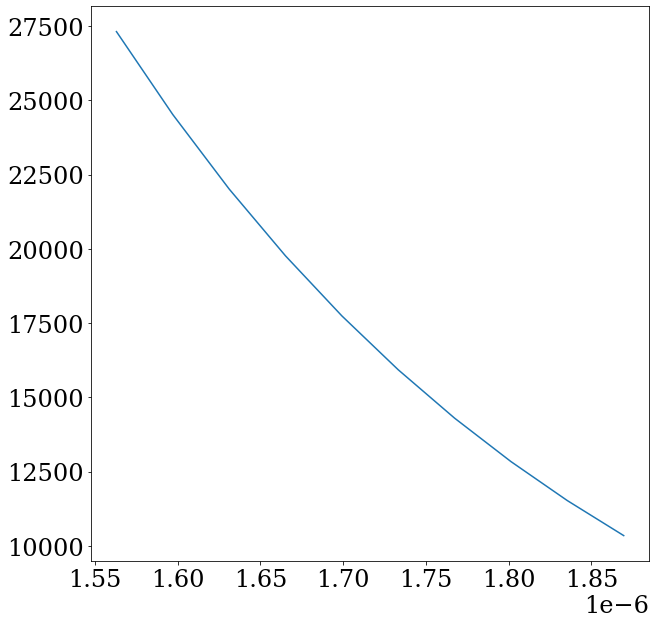

In [186]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F170M", nwavels=nwavels)

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("spectrum.LHS1846_F170M")).weights))#), yerr = spectrum_err)


In [187]:
no

NameError: name 'no' is not defined

In [ ]:
bad = np.ones((wid, wid))

In [ ]:
for i in range(8):
    pst = posterior(models[-1].inject(model_single),exposures_single[0],return_im=True)
    idx = np.unravel_index(np.nanargmax(pst*bad), pst.shape)
    bad = bad.at[idx].set(np.nan)


In [ ]:
extra_bad = np.isnan(bad)

In [ ]:
idx

(Array(50, dtype=int64), Array(58, dtype=int64))

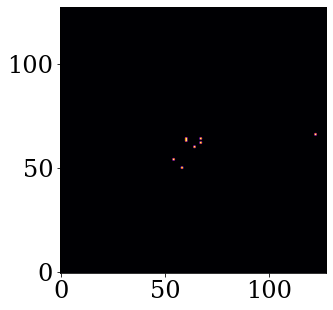

In [ ]:
plt.imshow(extra_bad)

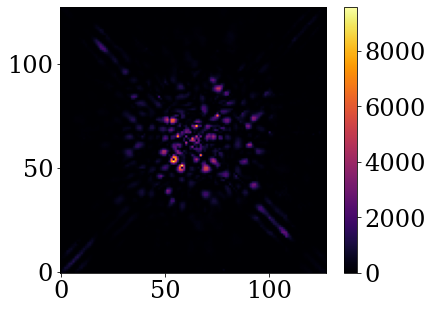

In [ ]:
plt.imshow(pst*(1-extra_bad))
plt.colorbar()

In [ ]:
jsp.stats.norm.logpdf(0,0,0.1)

Array(1.38364656, dtype=float64, weak_type=True)